Predicted labels:  [0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1]
Real labels:  [0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1]
Accuracy:  0.85


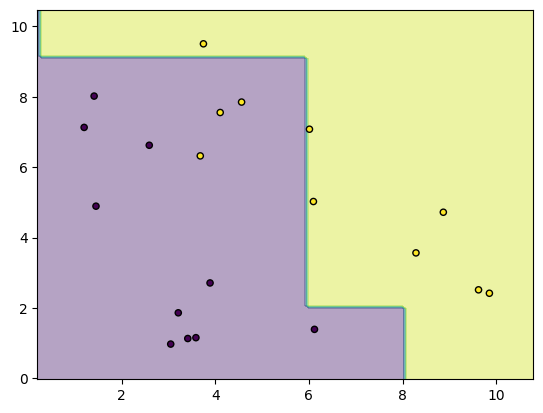

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def gini(y):
    """
    Calculate the Gini impurity for an array of labels.

    Parameters:
        y (numpy.ndarray): Array of labels.

    Returns:
        float: Gini impurity.
    """
    m = len(y)
    return 1 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

def split_dataset(X, y, feature_index, threshold):
    """
    Splits the dataset based on a feature and a threshold.

    Parameters:
        X (numpy.ndarray): The input features.
        y (numpy.ndarray): The target values.
        feature_index (int): The index of the feature to split on.
        threshold (float): The threshold value to split at.

    Returns:
        tuple: Left and right subsets of features and labels.
    """
    left_mask = X[:, feature_index] <= threshold
    right_mask = X[:, feature_index] > threshold
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

class DecisionTreeNode:
    """
    Represents a node in the Decision Tree.

    Attributes:
        feature_index (int): Index of the feature to split on.
        threshold (float): Threshold value for the split.
        left (DecisionTreeNode): Left child node.
        right (DecisionTreeNode): Right child node.
        value (float): Class value for leaf nodes.
    """
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    """
    A simple Decision Tree classifier.

    Attributes:
        max_depth (int): The maximum depth of the tree.
        min_samples_split (int): The minimum number of samples required to split an internal node.
        root (DecisionTreeNode): The root node of the tree.
    """
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        """
        Fits the Decision Tree classifier to the training data.

        Parameters:
            X (numpy.ndarray): The input features.
            y (numpy.ndarray): The target values.
        """
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        """
        Recursively builds the Decision Tree.

        Parameters:
            X (numpy.ndarray): The input features.
            y (numpy.ndarray): The target values.
            depth (int): The current depth of the tree.

        Returns:
            DecisionTreeNode: The root node of the built tree.
        """
        m, n = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or m < self.min_samples_split or num_labels == 1:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y)
        left_X, right_X, left_y, right_y = split_dataset(X, y, best_feature, best_threshold)

        if len(left_y) == 0 or len(right_y) == 0:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        left_child = self._build_tree(left_X, left_y, depth + 1)
        right_child = self._build_tree(right_X, right_y, depth + 1)
        return DecisionTreeNode(best_feature, best_threshold, left_child, right_child)

    def _best_split(self, X, y):
        """
        Finds the best feature and threshold to split on.

        Parameters:
            X (numpy.ndarray): The input features.
            y (numpy.ndarray): The target values.

        Returns:
            tuple: The index of the best feature and the best threshold value.
        """
        m, n = X.shape
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(n):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_y = y[X[:, feature_index] <= threshold]
                right_y = y[X[:, feature_index] > threshold]
                gini_left = gini(left_y)
                gini_right = gini(right_y)
                weighted_gini = (len(left_y) / m) * gini_left + (len(right_y) / m) * gini_right

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def _most_common_label(self, y):
        """
        Finds the most common label in the array of labels.

        Parameters:
            y (numpy.ndarray): Array of labels.

        Returns:
            int: The most common label.
        """
        return np.bincount(y).argmax()

    def predict(self, X):
        """
        Predicts the class labels for the input features.

        Parameters:
            X (numpy.ndarray): The input features.

        Returns:
            numpy.ndarray: The predicted class labels.
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """
        Recursively traverses the tree to make a prediction.

        Parameters:
            x (numpy.ndarray): A single data point.
            node (DecisionTreeNode): The current node in the tree.

        Returns:
            int: The predicted class label.
        """
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

# Generate random data for classification
np.random.seed(42)
X = np.random.rand(100, 2) * 10
y = (X[:, 0] + X[:, 1] > 10).astype(int)

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)

# Prediction on test set
y_pred = tree.predict(X_test)

# Print results
print("Predicted labels: ", y_pred)
print("Real labels: ", y_test)

# Calculate accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy: ", accuracy)

def plot_decision_boundary(tree, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.show()

plot_decision_boundary(tree, X_test, y_test)